## Add tracks to playlist
#### imports

In [1]:
import sys
# import utils
import pygn
from defs import pldesc, trdesc, SpotipyClient
from defs import make_trdesc
import time
import pandas as pd
from collections import defaultdict

def add_tracks_to_playlist_id(sp, playlist_id, tracklist):
    chunksize = 50
    numtracks = len(tracklist)
    for offset in [i for i in range(0, numtracks, chunksize)]:
        listslice = tracklist[offset:offset+chunksize]
        results = sp.spotify.user_playlist_add_tracks(sp.user, playlist_id, listslice)
        print(results)
        time.sleep(5)


In [2]:
# Prepping data
surveydf = pd.read_pickle('/Users/feelharmonic/Dropbox/Insight2018/SaReGaMood/playlists/allsurveys.pkl')

# mood_lists
survey_serious       = surveydf.loc[surveydf.label == 'serious', 'trackid'].tolist()
survey_peaceful      = surveydf.loc[surveydf.label == 'peaceful', 'trackid'].tolist()
survey_romantic      = surveydf.loc[surveydf.label == 'romantic', 'trackid'].tolist()
survey_sad           = surveydf.loc[surveydf.label == 'sad', 'trackid'].tolist()
survey_happy         = surveydf.loc[surveydf.label == 'happy', 'trackid'].tolist()
survey_lively        = surveydf.loc[surveydf.label == 'lively', 'trackid'].tolist()
survey_pining        = surveydf.loc[surveydf.label == 'pining', 'trackid'].tolist()
survey_transcendental= surveydf.loc[surveydf.label == 'transcendental', 'trackid'].tolist()
survey_contemplative = surveydf.loc[surveydf.label == 'contemplative', 'trackid'].tolist()
survey_sentimental   = surveydf.loc[surveydf.label == 'sentimental', 'trackid'].tolist()
survey_easygoing   = surveydf.loc[surveydf.label == 'easygoing', 'trackid'].tolist()

print(type(survey_serious))
print(survey_serious)

<class 'list'>
['48eVr7P5g5GI4INEmFZIEt', '1VV6MUnCIJBneYGyJBWwH4', '7f1D9ThXqJdsFnlwmyk0U7', '7jmvfoNL9iC8CwXeqsRkA2', '1eOSlegZ8QoNqVUT6ABhal', '5STPb6aKTsh66GZe6MBcId', '0nnvCnaW38vD5tirWf5HJu', '6TScHH0S2qsOm2gKkHytmt', '4y1wURdc1iIxfuYfIj9xYS', '6w8e0J7HPN47NQ7IRRAwTI', '1hOEAwvp8f71IBnAClAqs9', '1hYxNlVa84SwbEMgiuxmgb', '1cWkucJ05tiwH5AMOLGFm0', '7oDCqI6qYIc2ebiduj7RkM', '4r3dVLtNBFh0Db0pNjxx6X', '2M3lIs0J3xdbtdOa0X4wrj', '572bL1MnB6YtrYnZAUXJzd', '71YkmA0RzrXWR1z5u9HI3j', '0Df59aTZioumHtSCru4RCw', '12D7OTMpFHotkZwnIedjg0', '5YKjVmyBlnM28q0nIZXE7e', '1zHbW7Ta83uhyuQIjv4noY', '0477NJe5cvdNzoIQj0UShh', '5mWxp4yoG1lgt0tsbuIXzg', '0sEwHAbJix7mWE29ePHJvB', '5SKMRVAEmkCDqoqpgf0XaH']


In [6]:
sp = SpotipyClient()
pid="2eFAINBBFUN9JEDp17otc9"
tracklist = survey_sentimental
print(dir(sp))
# add_tracks_to_playlist_id(sp, pid, tracklist)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'auth', 'client', 'cred_manager', 'id', 'secret', 'spotify', 'user']


## Mega survey ~ 300 labeled data points


In [8]:
import psycopg2
import pandas as pd
import sys

import pickle
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
from sklearn import cluster

import numpy as np
from scipy.stats import kde
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.cluster import AffinityPropagation
from sklearn.metrics.pairwise import euclidean_distances
from sklearn import metrics
from sklearn.preprocessing import scale

from sklearn.mixture import GaussianMixture
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import scipy

sns.set_style("whitegrid", {'axes.grid' : False})

# create connection
def get_db_handle(dbname="testdb", rolename ="spotify"):
    con = None
    constr = "host='localhost' dbname='"+dbname+"'  user='"+rolename+"' password='ics'"
    try:
        con = psycopg2.connect(constr)
    except Exception as e:
        if con: 
            con.rollback()
        print('Error creating or connecting handle', str(e))
        sys.exit(1)
    if con is None:
        print('Error creating handle', str(e))
        sys.exit(1)
    return con

# open a cursor and fetch db to a pandas dataframe
def query_db_translate_to_pandas(con, querystring):
    df = None
    try:
        cur = con.cursor()
        df = pd.read_sql(querystring, con)
    except Exception as e:
        con.rollback() # meaning break the connection safely
        print("Error in printing table", str(e))
    return df

def close_db(handle1):
    if handle1:
        handle1.close()
    return



#### Get data

In [9]:
# get all tracks

con = get_db_handle()
print(con)
querystr = "select * from alltracks"
df = query_db_translate_to_pandas(con, querystr)
df.columns

con = get_db_handle()
querystr = "select * from ragafeaturedb"
    #where name like \'%Shri%\'"
df = query_db_translate_to_pandas(con, querystr)
print(df.columns)

<connection object at 0x10da89420; dsn: 'user=spotify password=xxx dbname=testdb host=localhost', closed: 0>
Index(['id', 'name', 'url', 'sp_danceability', 'sp_energy', 'sp_key',
       'sp_loudness', 'sp_mode', 'sp_speechiness', 'sp_acousticness',
       'sp_instrumentalness', 'sp_liveness', 'sp_valence', 'sp_tempo',
       'gn_gnid', 'gn_genre_1', 'gn_genre_2', 'gn_genre_3', 'gn_mood_1',
       'gn_mood_2', 'gn_tempo_1', 'gn_tempo_2', 'gn_tempo_3'],
      dtype='object')


#### Unsupervised clustering on ALL spotify data


In [10]:
# 
df_allData = df
X = df_allData[["sp_valence", "sp_energy", "sp_danceability", "sp_speechiness", "sp_acousticness", "sp_instrumentalness", "sp_tempo"]].astype('float64') #'sp_danceability', 'sp_energy', 'sp_key',
# # normalizing
X = X.as_matrix(columns=None) #imports X as numpy matrix
X_normed = X / X.max(axis=0)
X= X_normed

# from sklearn.preprocessing import normalize
X_allData = X

(7115, 7)
<class 'numpy.ndarray'>


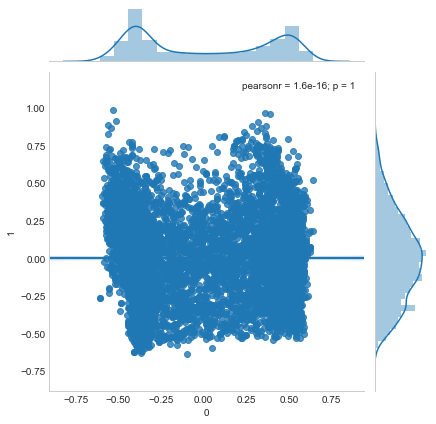

In [11]:
## PCA
from sklearn.decomposition import PCA
print(X.shape)
pca = PCA(n_components=2)
X_PCA = pca.fit(X).transform(X)
print(type(X_PCA))
X_myPCA = pd.DataFrame(data=X_PCA)
sns.jointplot(x = X_myPCA[0], y = X_myPCA[1], data = X_myPCA, kind = 'reg')

11 0.398526736713
[ 0  0  0 ..., 10 10 10]


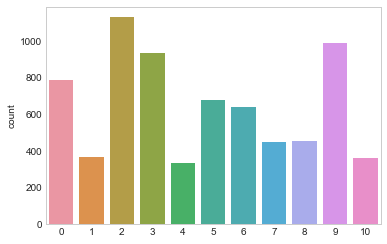

In [13]:
# K-means clustering on the IND dataset
# takes n_clusters as input

Y = X_myPCA

# for n in range(10):
n_clusters = 11
k_means = cluster.KMeans(n_clusters)
k_means.fit(Y) 
y_kmeans = k_means.predict(Y)

clusterer = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(Y)
silhouette_avg = silhouette_score(Y, cluster_labels)
print(n_clusters, silhouette_avg)
cluster_labels = np.sort(cluster_labels)
print(cluster_labels)
sns.countplot(cluster_labels)
all_data_cluster_centers = k_means.cluster_centers_

#### Grouping the labeled data

In [14]:
surveydf = pd.read_pickle('/Users/feelharmonic/Dropbox/Insight2018/SaReGaMood/playlists/allsurveys.pkl')
print(surveydf.label)

0       contemplative
1       contemplative
2       contemplative
3       contemplative
4       contemplative
5       contemplative
6       contemplative
7       contemplative
8       contemplative
9       contemplative
10      contemplative
11      contemplative
12      contemplative
13      contemplative
14      contemplative
15      contemplative
16      contemplative
17      contemplative
18      contemplative
19      contemplative
20      contemplative
21      contemplative
22      contemplative
23      contemplative
24      contemplative
25      contemplative
26      contemplative
27      contemplative
28      contemplative
29      contemplative
            ...      
273           serious
274           serious
275           serious
276           serious
277           serious
278           serious
279           serious
280           serious
281           serious
282           serious
283           serious
284           serious
285           serious
286           serious
287       

In [16]:
gnmoodset = set(list(surveydf['gn_mood_1']))
gnmoodsetlower = {elem.lower() for elem in gnmoodset}
mymoodset = set(list(surveydf['label']))
gnminusmy = gnmoodsetlower - mymoodset
print(gnmoodset)
print(gnminusmy)
print(gnmoodsetlower & mymoodset)

common = {'romantic', 'sentimental', 'easygoing', 'peaceful', 'serious', 'lively'}
m1list = mymoodset
m2list = {'Peaceful', 'Serious', 'Somber', 'Fiery', 'Gritty', 'Easygoing', 'Romantic', 'Sentimental', 'Melancholy', 'Sophisticated', 'Sensual'}
print(m2list - gnmoodset)

# {'gritty', 'fiery', 'melancholy', 'tender', 'urgent', 
# stirring', 'sophisticated', 'rowdy', 'sensual', 'somber', 'brooding'}

{'Brooding', 'Peaceful', 'Serious', 'Sophisticated', 'Gritty', 'Rowdy', 'Sensual', 'Tender', 'Fiery', 'Sentimental', 'Urgent', 'Somber', 'Romantic', 'Easygoing', 'Melancholy', 'Lively', 'Stirring'}
{'rowdy', 'tender', 'gritty', 'fiery', 'stirring', 'sensual', 'urgent', 'sophisticated', 'somber', 'brooding', 'melancholy'}
{'peaceful', 'easygoing', 'romantic', 'lively', 'sentimental', 'serious'}
set()


In [17]:
# extract spotify features as numpy matrix 
labeled_spfeat = surveydf[['nsp_acousticness', 'nsp_danceability', 'nsp_energy', 'nsp_instrumentalness', 'nsp_liveness', 'nsp_loudness',
                      'nsp_speechiness', 'nsp_tempo', 'nsp_valence']]
labeled_sp = labeled_spfeat.as_matrix()

(303, 9)
<class 'numpy.ndarray'>


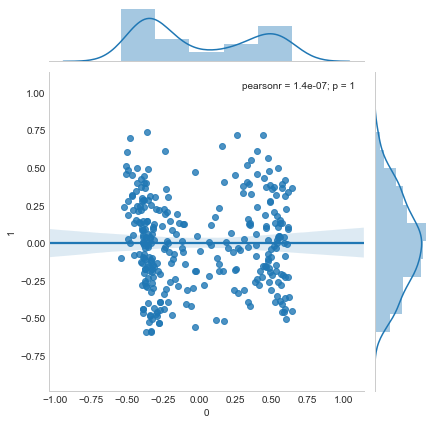

In [18]:
## PCA
print(labeled_sp.shape)
pca = PCA(n_components=2)
Xs_PCA = pca.fit(labeled_sp).transform(labeled_sp)
print(type(Xs_PCA))
Xs_myPCA = pd.DataFrame(data=Xs_PCA)
sns.jointplot(x = Xs_myPCA[0], y = Xs_myPCA[1], data = Xs_myPCA, kind = 'reg')

In [19]:
# Now read surveydf as a list of dictionaries
surveydict = surveydf.to_dict(orient='records')
moodlist = ['serious', 'peaceful', 'sad', 'happy', 'pining', 'contemplative', 'transcendental',
             'easygoing', 'lively', 'sentimental', 'romantic']
featkeys = ['nsp_acousticness', 'nsp_danceability', 'nsp_energy', 'nsp_instrumentalness', 'nsp_liveness', 'nsp_loudness',
            'nsp_speechiness', 'nsp_tempo', 'nsp_valence']

moodtoveclist = {mood: [] for mood in m1list}
centroidlist = {}
for mood in m1list:
    #moodtoveclist[mood] = [ labeled_sp[i] for i,row in enumerate(surveydict) if row['label'] == mood ]
    moodtoveclist[mood] = [ [row[key] for key in featkeys] for i,row in enumerate(surveydict) if row['label'] == mood ]
    centroidlist[mood] = np.mean(moodtoveclist[mood], axis=0)
    print("ICM mood = ", mood, centroidlist[mood])
    
# Repeat the calculation for gracenotemoodlist
# input is gnmoodlist, featkeys is the same
gnmoodtoveclist = {mood: [] for mood in m2list}
gncentroidlist = {}
for mood in m2list:
    #gnmoodtoveclist[mood] = [ labeled_sp[i] for i,row in enumerate(surveydict) if row['gn_mood_1'] == mood ]
    gnmoodtoveclist[mood] = [ [row[key] for key in featkeys] for i,row in enumerate(surveydict) if row['gn_mood_1'] == mood ]
    gncentroidlist[mood] = np.mean(gnmoodtoveclist[mood], axis=0)
    print("GN Mood = ", mood, gncentroidlist[mood])

def compute_nearest_neighbors(m2vlist, dictcentroid):
    # Combine all the vectors to begin with
    allvecs = []
    distances = []
    for mood in m2vlist:
        allvecs.extend(m2vlist[mood])
    print(len(allvecs))
    tree = scipy.spatial.KDTree(list(dictcentroid.values()))
    for i, row in enumerate(allvecs):
        dist, idx = tree.query(row, 1)
        distances.append(dist)
    return distances
        
distances = compute_nearest_neighbors(moodtoveclist, centroidlist)
gndistances = compute_nearest_neighbors(gnmoodtoveclist, gncentroidlist)

print(np.mean(distances), np.percentile(distances, [10*i for i in range(1,10)]))
print(np.mean(gndistances), np.percentile(gndistances, [10*i for i in range(1,10)]))

ICM mood =  serious [ 0.72096077  0.38291244  0.44785339  0.21786124  0.22302586  0.25002692
  0.06141662  0.52417111  0.31097774]
ICM mood =  peaceful [ 0.81089063  0.3887689   0.36322055  0.54965139  0.23452804  0.26662304
  0.05148456  0.53418146  0.33062569]
ICM mood =  easygoing [ 0.79497992  0.47434124  0.40184368  0.50228484  0.2112237   0.27812533
  0.05442027  0.53842637  0.37225052]
ICM mood =  romantic [ 0.70546473  0.37588707  0.51202403  0.31411847  0.24161682  0.21930952
  0.06872077  0.52217412  0.43194486]
ICM mood =  transcendental [ 0.823567    0.43579423  0.35592092  0.55543048  0.27347016  0.25405303
  0.05363348  0.53525879  0.30639351]
ICM mood =  happy [ 0.71741968  0.46087114  0.5027722   0.39899523  0.25442629  0.22824111
  0.06363956  0.52825905  0.42543122]
ICM mood =  contemplative [ 0.73467834  0.31512083  0.32013592  0.24133829  0.29985546  0.26605944
  0.04688091  0.49979682  0.20197397]
ICM mood =  lively [ 0.68421783  0.4398591   0.56508968  0.54385149 

In [20]:
# grouping the points with same label together
label_clusters = {} # consists of all ids of songs which are in each category in label_dict
label_vectors = {}
label_dict = {0:'serious', 1:'peaceful', 2:'sad', 3:'happy', 4:'pining', 5: 'contemplative', 6: 'transcendental',
             7: 'easygoing', 8:'lively', 9:'sentimental', 10: 'romantic'}


for label_idx, value in label_dict.items():
    some_list = [surveydf['label'] == label_dict[label_idx]]
    for e in some_list:
        label_clusters.update({label_idx: surveydf.index[e]})

In [23]:
print(label_clusters[5][:])

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52],
           dtype='int64')


In [24]:
print(surveydf.shape[0])

303
